
# Lab Assignment Two: Exploring Image Data





# 1. Business Understanding

This dataset is created as a benchmark dataset for the work on Effects of Degradations on Deep Neural Network Architectures.

In this lab, the goal is to categorize each image from a dataset into 8 distinct classes. These classes are airplane, car, cat, dog, flower, fruit, motorbike, and person. The dataset contains 6899 images consisting of the aforementioned classes. The goal of this lab is to be able to train an algorithm to accurately classify these classes. The goal is to be able to identify each image as either "natural" (cat, dog, flower, fruit, person) or "unnatural" (airplane, car, motorbike).

This algorithm could be valuable from a military perspective in limiting civilian casualties. For example, missiles could only target military vehicles or factories, while avoiding civilians. Our prediction algorithm needs to have at least a 85-90% accuracy for it to be useful. Third parties such as the military would most likely be interested in the results because they would most likely want to limit unnecessary civilian casualties.

# Dataset Description
Dataset: Natural Images

Description: A dataset of 8 different classes with 6899 images. Each class has its own folder.In this lab, we chose to classify these classes as either "natural" or "unnatural" for the classification task.


url: https://www.kaggle.com/datasets/prasunroy/natural-images


# 2. Data Preparation

Reading in data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
import glob
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')


def readDataAndGetLabel(image_paths_with_labels):
    data = []
    label = []

    # Iterate over the provided paths and their corresponding labels
    for path_pattern, each_label in image_paths_with_labels:
        # Use glob to match all images in the path
        for img_path in glob.glob(path_pattern):
            readimg = cv2.imread(img_path)
            if readimg is not None:  # Ensure the image is read successfully
                data.append(readimg)
                label.append(each_label)

    return data, label

# List of paths with their corresponding labels, MAKE SURE YOU UPLOAD THE FILES TO A FOLDER CALLED 'lab2' in your google drive
# Might go through and just cut the number of folders to analyze in half to save time
image_paths_with_labels = [
    ('/content/drive/MyDrive/lab2/airplane/*', 'unnatural'),
    ('/content/drive/MyDrive/lab2/car/*', 'unnatural'),
    ('/content/drive/MyDrive/lab2/cat/*', 'natural'),
    ('/content/drive/MyDrive/lab2/dog/*', 'natural'),
    ('/content/drive/MyDrive/lab2/flower/*', 'natural'),
    ('/content/drive/MyDrive/lab2/fruit/*', 'natural'),
    ('/content/drive/MyDrive/lab2/motorbike/*', 'unnatural'),
    ('/content/drive/MyDrive/lab2/person/*', 'natural')
]

# Use the function with the provided paths and labels
X, Y = readDataAndGetLabel(image_paths_with_labels)

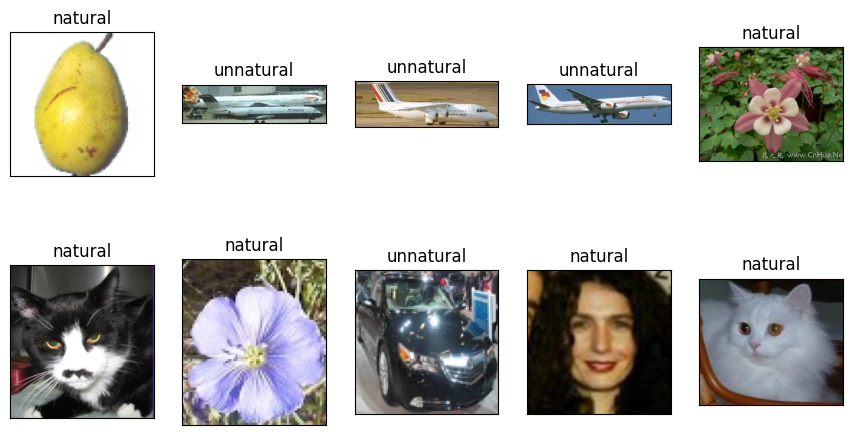

In [ ]:
def randomShowImg(data, label, imRange, n_row=2, n_col=5):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        index = random.randint(0, imRange - 1)  # Randomly select an image index, adjusting range to 0-based indexing
        img = data[index]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(img_rgb)
        plt.title(label[index], size=12)  # Use the label directly from the 'label' array
        plt.xticks(())
        plt.yticks(())

randomShowImg(X, Y, len(X))

# 2.1 Data Preparation
We first prepare the image data by linearizing the images, converting them into a table of 1D image features. This process involves resizing each image to a common size, flattening them into one-dimensional arrays, and scaling the pixel values to a range between 0 and 1. This standardized representation of the images is essential for training machine learning models effectively. By converting the images into a uniform format, we ensure that the algorithms can process them efficiently and that all features contribute equally to the learning process.

In [ ]:
import numpy as np

# Define a common size for all images.
common_size = (50, 50)

# Convert and resize all the image data in 'X' to a NumPy array and reshape each image into a flat array
npX = np.array([cv2.resize(img, common_size).reshape(-1) for img in X])

# Convert labels in 'Y' to a NumPy array
npY = np.array(Y)

# Scale all pixel values in the images to the range 0-1
npX_scaled = npX / 255.0

# Print shapes of the arrays to verify
print(f"Data shape: {npX_scaled.shape}")
print(f"Labels shape: {npY.shape}")

# Additional information based on your dataset
print(f"There are {npX_scaled.shape[0]} samples in the dataset.")

Data shape: (6919, 7500)
Labels shape: (6919,)
There are 6919 samples in the dataset.


[[0.89411765 0.97254902 0.99215686 ... 0.62745098 0.74509804 0.78039216]
 [0.78039216 0.79215686 0.69019608 ... 0.02745098 0.3372549  0.34117647]
 [0.67843137 0.60392157 0.47843137 ... 0.11372549 0.40392157 0.55294118]]


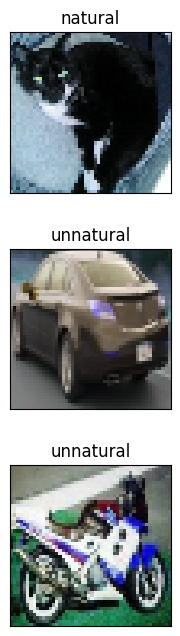

In [ ]:
def randomShowImg(data, labels, imRange, n_row=2, n_col=5, image_shape=(50, 50, 3)):
    plt.figure(figsize=(2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        index = random.randint(0, imRange - 1)  # Randomly select an image index
        img_1d = data[index]  # Get the 1-D array of the selected image
        img_2d = img_1d.reshape(image_shape)  # Reshape it back to its original shape (including 3 channels for RGB)

        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(img_2d)
        plt.title(labels[index], size=12)
        plt.xticks(())
        plt.yticks(())


# Usage example
# Adjusted usage example with the correct image shape for color images
#randomShowImg(npX_scaled, npY, len(npX_scaled), n_row=3, n_col=4, image_shape=(100, 100, 3))
print(npX_scaled[:3])
randomShowImg(npX_scaled, npY, len(npX_scaled), n_row=3, n_col=1, image_shape=(50, 50, 3))

# 3.1 Data Reduction
In the data reduction step, we fit PCA models to the scaled image data, testing two different methods: the full singular value decomposition solver vs. a randomized solver. PCA allows us to represent images in a lower-dimensional space while preserving essential information. This facilitates faster computation and potentially improves the performance of machine learning algorithms used later.

In [ ]:
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Perform PCA
n_components = 600  # Specify the number of components - lower means faster computing but less quality, we want to retain around 95% of variance, so need to find sweet spot
print(f"Extracting the top {n_components} principal components from {npX_scaled.shape[0]} images")

# Initialize and fit PCA - 276 seconds
pca = PCA(n_components=n_components, svd_solver='full')
start_time = time.time()
pca.fit(npX_scaled)
end_time = time.time()
print(f"PCA fitting completed in {end_time - start_time} seconds")

Extracting the top 600 principal components from 6919 images
PCA fitting completed in 355.6827201843262 seconds


In [ ]:
# Initialize and fit - 43 seconds
start_time = time.time()
rpca = PCA(n_components=n_components, svd_solver='randomized')
rpca.fit(npX_scaled)
end_time = time.time()
print(f"RPCA fitting completed in {end_time - start_time} seconds")

RPCA fitting completed in 46.376386404037476 seconds


Interpreting these times, we observe a significant difference in the computational efficiency between the two methods. While the full SVD solver computes the exact decomposition of the covariance matrix, the randomized solver employs approximation techniques that are more efficient, particularly for high-dimensional data.

We now proceed with visualizing explained variance for the PCA model.

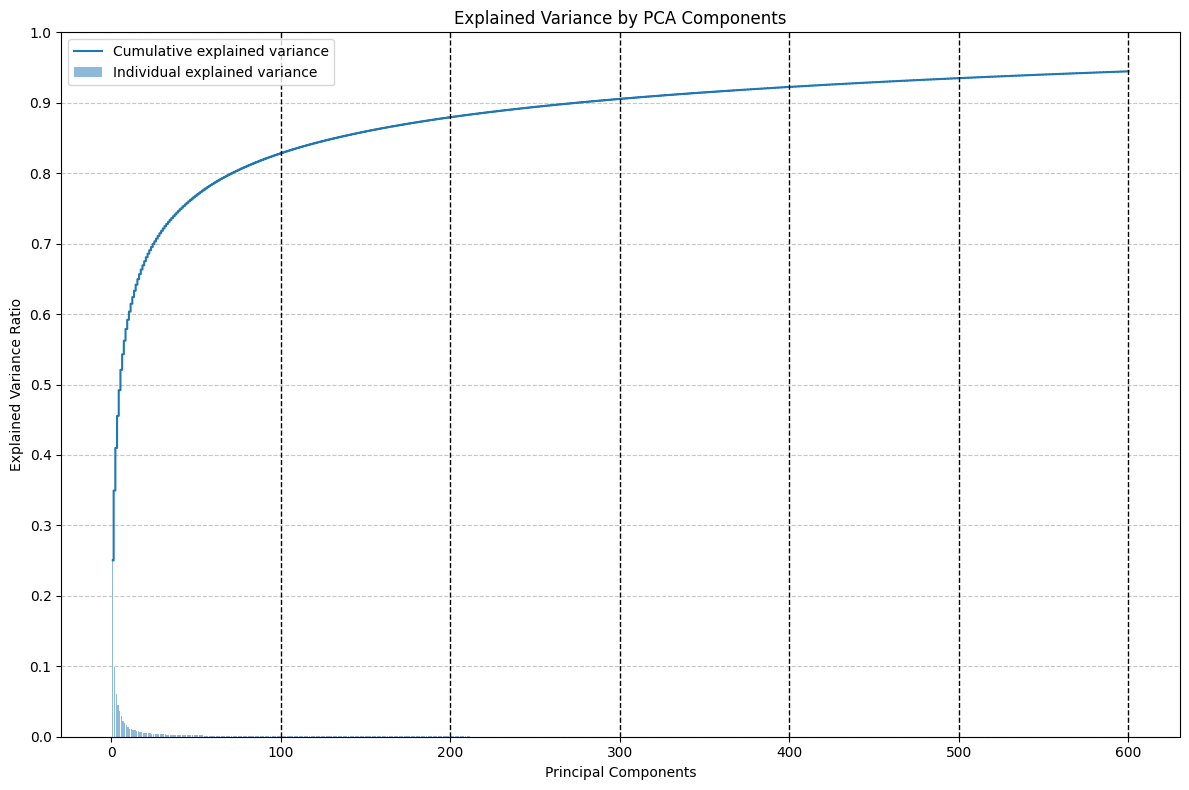

In [ ]:
def plot_explained_variance(pca_model):
    explained_variance = pca_model.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_variance)

    plt.figure(figsize=(12, 8))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(explained_variance) + 1), cum_var_exp, where='mid',
             label='Cumulative explained variance')

    plt.ylabel('Explained Variance Ratio')
    plt.yticks(np.arange(0, 1.1, 0.1))

    plt.xlabel('Principal Components')
    plt.title('Explained Variance by PCA Components')
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Draw vertical lines at each x=100 on the axis
    for x in range(100, len(explained_variance) + 1, 100):
        plt.axvline(x=x, color='black', linestyle='--', linewidth=1)  # Change 'color', 'linestyle', 'linewidth' as needed

    plt.tight_layout()
    plt.show()

# Visualize explained variance for PCA
plot_explained_variance(pca)

The cumulative variance plot starts to level off at around 50 principal components, which suggests that a significant portion of the variance in the image data can be explained by a relatively small number of components. This indicates that the intrinsic characteristics distinguishing between natural and unnatural images may be captured within this reduced space, and that this may be the point where we may strike a balance between preserving relevant information for classification and minimizing the dimensionality of our data.

The individual explained variance plot stops at around 50 principal components, which reinforces the finding from the cumulative variance plot. This suggests that each additional principal component beyond the first ~50 contributes only marginally to explaining the variance in the data.

In [ ]:
def display_explained_variance_table(pca_model):
    explained_variance = pca_model.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_variance)

    # Creating a DataFrame
    df = pd.DataFrame({
        'Component': range(1, len(explained_variance) + 1),
        'Explained Variance': explained_variance,
        'Cumulative Explained Variance': cum_var_exp
    })

    # Setting the 'Component' column as the index
    df.set_index('Component', inplace=True)

    # Displaying the DataFrame
    print(df)

# Example usage assuming 'pca' is your fitted PCA model
display_explained_variance_table(pca)

           Explained Variance  Cumulative Explained Variance
Component                                                   
1                    0.250313                       0.250313
2                    0.099200                       0.349514
3                    0.060404                       0.409917
4                    0.045599                       0.455517
5                    0.036436                       0.491952
...                       ...                            ...
596                  0.000087                       0.944279
597                  0.000087                       0.944366
598                  0.000087                       0.944453
599                  0.000087                       0.944540
600                  0.000087                       0.944627

[600 rows x 2 columns]


# 3.2 Data Reduction

We now perform linear dimensionality reduction of our image data using randomized principle components analysis.

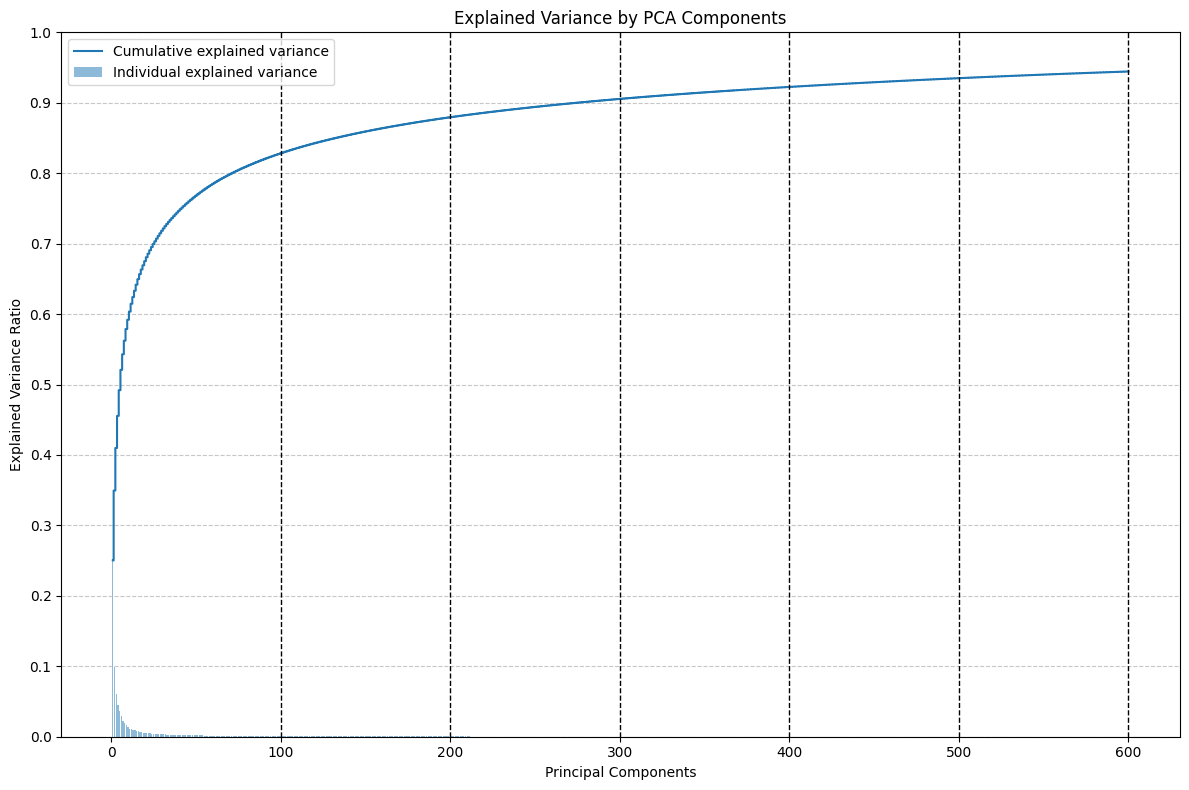

In [ ]:
plot_explained_variance(rpca)

The observed similarity in the patterns between the individual explained variance and cumulative variance plots for RPCA, mirroring those of the PCA results, underscores a consistent trend across both methods. This alignment indicates that around 50 principal components capture a substantial portion of the variance in the image data for RPCA as well. Consequently, beyond this point, the marginal gains in explaining variance with additional components diminish rapidly.

This coherence between PCA and RPCA findings suggests that despite using different algorithms for fitting, both methods identify a comparable optimal number of components. This congruence could stem from the inherent structure of the data, implying that the key features distinguishing natural from unnatural images are effectively captured within this reduced-dimensional space. Thus, adhering to approximately 50 principal components for RPCA aligns with our objective of striking a balance between computational efficiency and information retention for our classification task.

In [ ]:
display_explained_variance_table(rpca)

           Explained Variance  Cumulative Explained Variance
Component                                                   
1                    0.250313                       0.250313
2                    0.099200                       0.349514
3                    0.060404                       0.409917
4                    0.045599                       0.455517
5                    0.036436                       0.491952
...                       ...                            ...
596                  0.000082                       0.944069
597                  0.000082                       0.944151
598                  0.000082                       0.944233
599                  0.000082                       0.944315
600                  0.000081                       0.944396

[600 rows x 2 columns]


# 3.3 Data Reduction

In this section, we delve into a comparative analysis of image representations obtained through PCA and RPCA. We aim to assess the effectiveness of these dimensionality reduction techniques in capturing essential image features for our natural/unnatural image classification project. By reconstructing images in pairs using PCA and RPCA, we seek to evaluate the fidelity of the representations generated by each method. This comparative analysis will guide our selection of the optimal method for transforming image data.

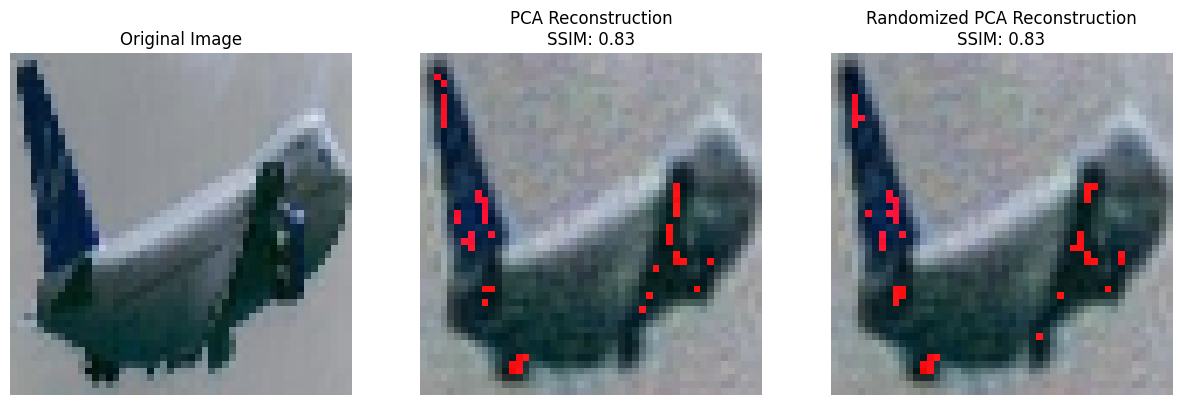

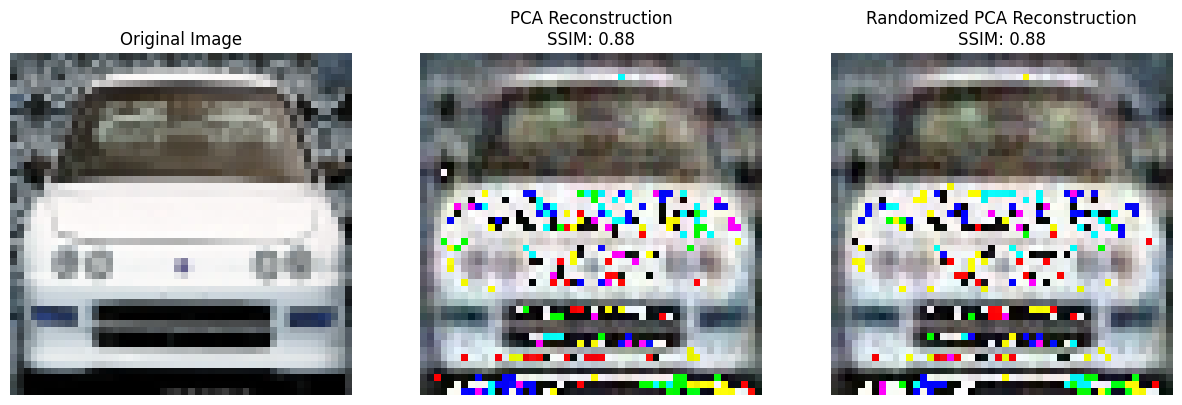

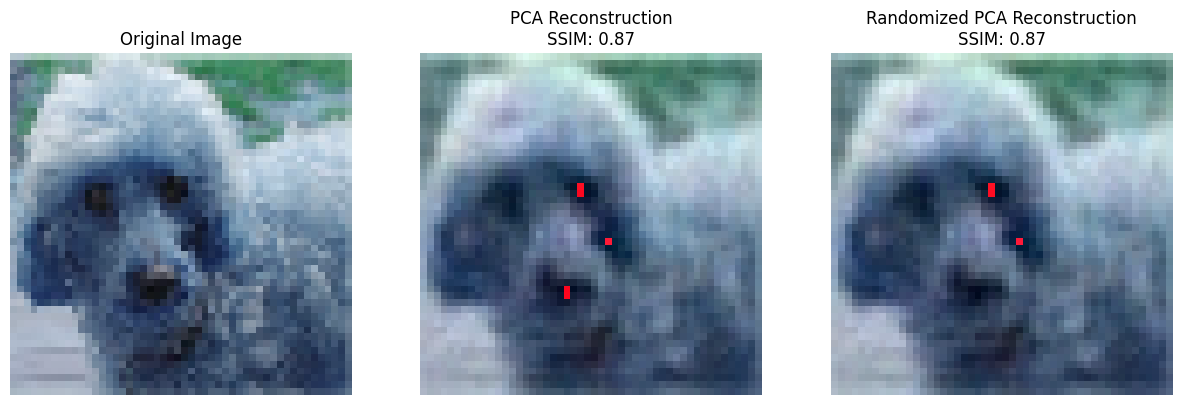

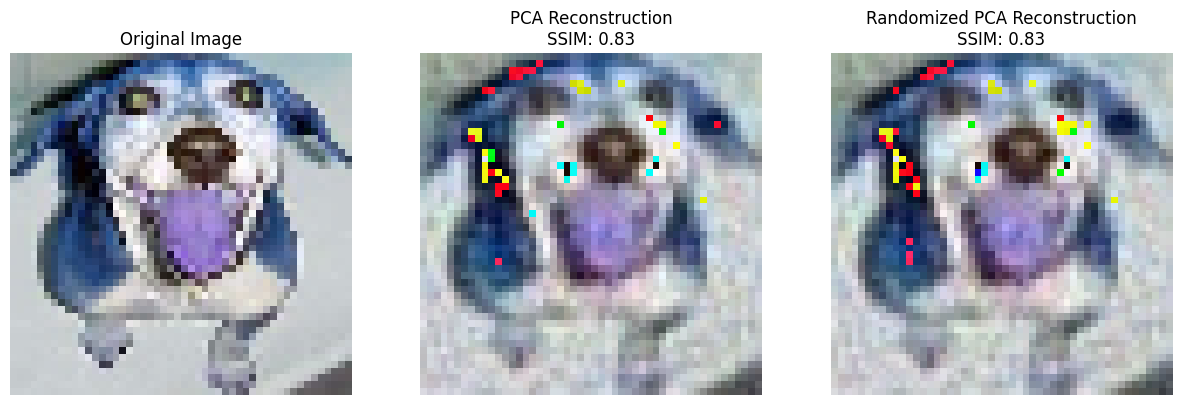

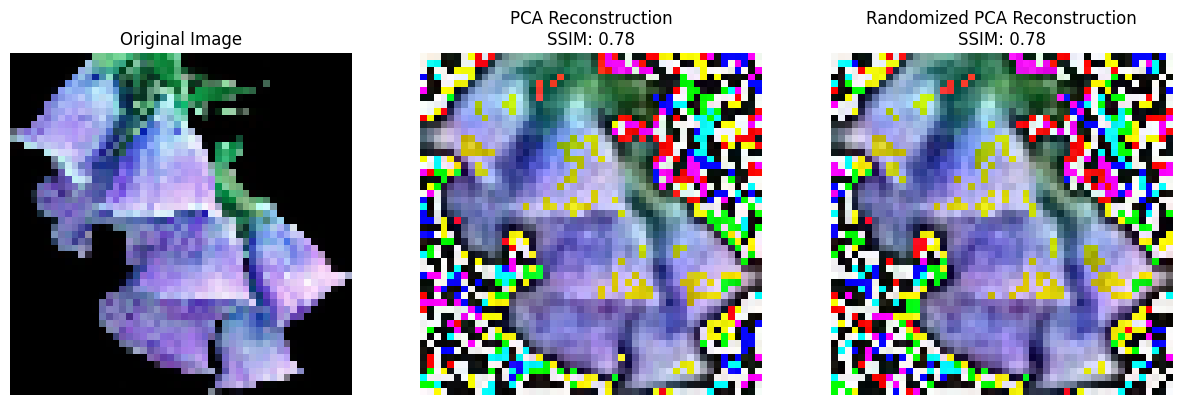

In [ ]:

# Reconstructs the images using PCA and RPCA and gets a SSIM score, higher score is better
def plt_reconstruct(pca_model, rpca_model):
    ranges = [(0, 1000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 4200)]
    random_indices = [random.randint(start, end) for start, end in ranges]

    for idx_to_reconstruct in random_indices:
        reconstructed_image_pca = pca_model.inverse_transform(pca_model.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))
        reconstructed_image_rpca = rpca_model.inverse_transform(rpca_model.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))

        original_image = npX_scaled[idx_to_reconstruct].reshape(50, 50, 3) * 255
        image_pca = reconstructed_image_pca.reshape(50, 50, 3) * 255
        image_rpca = reconstructed_image_rpca.reshape(50, 50, 3) * 255

        original_image_gray = np.dot(original_image[..., :3], [0.2989, 0.5870, 0.1140])
        image_pca_gray = np.dot(image_pca[..., :3], [0.2989, 0.5870, 0.1140])
        image_rpca_gray = np.dot(image_rpca[..., :3], [0.2989, 0.5870, 0.1140])

        win_size = 7
        ssim_pca = ssim(original_image_gray, image_pca_gray, win_size=win_size, data_range=original_image_gray.max() - original_image_gray.min(), use_sample_covariance=False)
        ssim_rpca = ssim(original_image_gray, image_rpca_gray, win_size=win_size, data_range=original_image_gray.max() - original_image_gray.min(), use_sample_covariance=False)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original_image.astype('uint8'))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(image_pca.astype('uint8'))
        axes[1].set_title(f'PCA Reconstruction\nSSIM: {ssim_pca:.2f}')
        axes[1].axis('off')

        axes[2].imshow(image_rpca.astype('uint8'))
        axes[2].set_title(f'Randomized PCA Reconstruction\nSSIM: {ssim_rpca:.2f}')
        axes[2].axis('off')

        plt.show()

# Example usage
plt_reconstruct(pca, rpca)


Here we see that the SSIM scores for the PCA and RPCA reconstructions are almost identical. This suggests that both methods are capable of preserving essential image features during the reconstruction process.

In [ ]:
from sklearn.metrics import mean_squared_error
# Calculates Reconstruction Error
reconstructed_pca = pca.inverse_transform(pca.transform(npX_scaled))
reconstructed_rpca = rpca.inverse_transform(rpca.transform(npX_scaled))

mse_pca = mean_squared_error(npX_scaled, reconstructed_pca)
mse_rpca = mean_squared_error(npX_scaled, reconstructed_rpca)

print(f"PCA Reconstruction MSE: {mse_pca}")
print(f"Randomized PCA Reconstruction MSE: {mse_rpca}")

PCA Reconstruction MSE: 0.004489109525340172
Randomized PCA Reconstruction MSE: 0.004507798504425626


These close values indicate that both PCA and RPCA achieve similar levels of reconstruction accuracy when compared using MSE.

In [ ]:
# Gets explained variance, higher variance means more information about data
explained_variance_pca = np.sum(pca.explained_variance_ratio_)
explained_variance_rpca = np.sum(rpca.explained_variance_ratio_)

print(f"Explained Variance by PCA: {explained_variance_pca}")
print(f"Explained Variance by Randomized PCA: {explained_variance_rpca}")


Explained Variance by PCA: 0.9446265200811663
Explained Variance by Randomized PCA: 0.9443959902172252


The high explained variance values for both PCA and RPCA suggest that the majority of the variance in the image data is preserved by the reduced-dimensional representations generated by both techniques. The overall similarity in explained variance shows that both PCA and RPCA are effective in retaining the essential information necessary for image classification tasks.

All in all, it looks like both PCA and RPCA offer reliable approaches for reducing the dimensionality of the image data while preserving the discriminative features essential for accurate classification.

# 3.4 Data Reduction

We now perform feature extraction using the Dense Intensity and Appearance Descriptor for Image Saliency (DAISY). This technique enables us to capture detailed and discriminative features from the image data, facilitating more robust and precise classification.

In [ ]:
from skimage.feature import daisy
from skimage.color import rgb2gray
from skimage.io import imshow
import numpy as np
import matplotlib.pyplot as plt

def convert_to_grey(image):
    # Assuming the image is in RGB format
    return rgb2gray(image)

def apply_daisy(img):
    # Apply DAISY feature extraction
    feat = daisy(img, step=20, radius=8, rings=3, histograms=5, orientations=8, visualize=False)
    return feat.reshape((-1))

def extra_feature(data):
    # Initialize an empty array to hold the DAISY features
    daisy_features = []

    for img_flat in data:
        img = img_flat.reshape(50, 50, 3)
        img_grey = convert_to_grey(img)

        # Extract DAISY features and append to the list
        feat = apply_daisy(img_grey)
        daisy_features.append(feat)

    # Convert the list of features to a numpy array
    return np.array(daisy_features)

# Reshape the images back to their original size if necessary and extract features, uses a copy of npX so it doesn't affect original
train_feature = extra_feature(npX_scaled.copy())

print(f'There are {train_feature.shape[0]} samples in the training set, and each sample has {train_feature.shape[1]} features.')


There are 6919 samples in the training set, and each sample has 512 features.


Each image is now characterized by a set of 512 features, which encapsulate salient intensity and appearance information. This feature representation is crucial for subsequent stages of our classification project, as it provides a more informative and discriminative representation of the image data compared to the original pixel values. Additionally, the high dimensionality of the feature space (512 dimensions) enables the classification model to capture intricate patterns and variations within the image data, potentially improving the model's ability to discern between natural and unnatural images.

# 3.5 Data Reduction
To determine whether DAISY shows promise for predicting whether the images are natural or unnatural, we visualize the difference between statistics of extracted features in each target class, use a heat map of the pairwise differences (ordered by class) among all extracted features, and build a nearest neighbor classifier to see actual classification performance.

Visualizing the differences between statistics of extracted features in each target class:

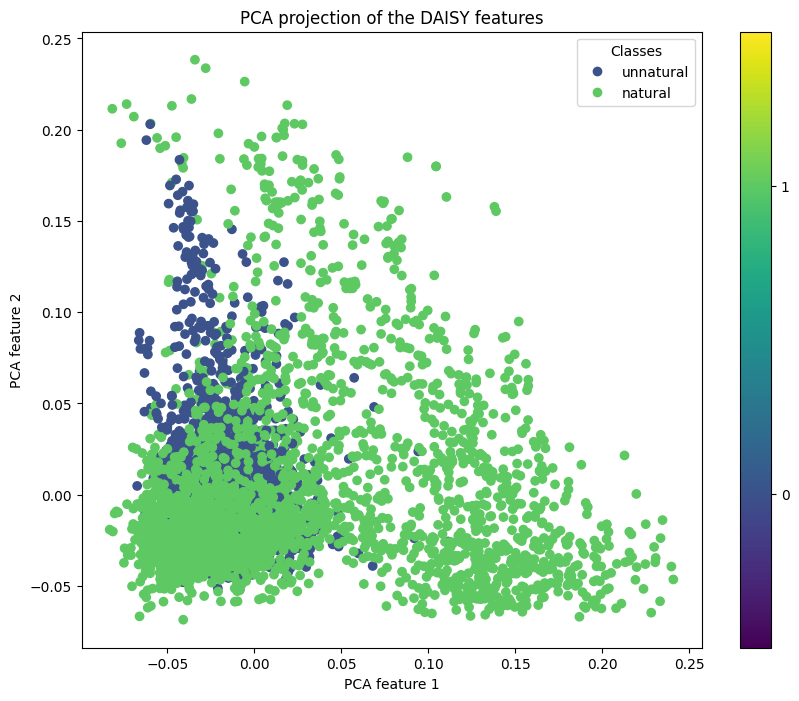

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA
pca = PCA(n_components=2)

# Reduce dimensions
X_pca = pca.fit_transform(train_feature)

# Map class labels to integers
class_mapping = {'unnatural': 0, 'natural': 1}
y_mapped = np.array([class_mapping[label] for label in npY])

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.clim(-0.5, 1.5)
plt.legend(handles=scatter.legend_elements()[0], labels=class_mapping.keys(), title="Classes")
plt.title('PCA projection of the DAISY features')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()



There is no class separation or decision boundary. It appears, then, that PCA on the DAISY features does not do a great job of distinguishing between natural and unnatural images. Since the unnatural cluster is contained inside the natural one, we could say that, with only two components, a ML model could potentially be able to classify natural images with some amount of accuracy but poor recall.

Using a heat map of the pairwise differences (ordered by class) among all extracted features:

Average Intra-class Distance: 0.1848583894268993
Average Inter-class Distance: 0.18254083101143775


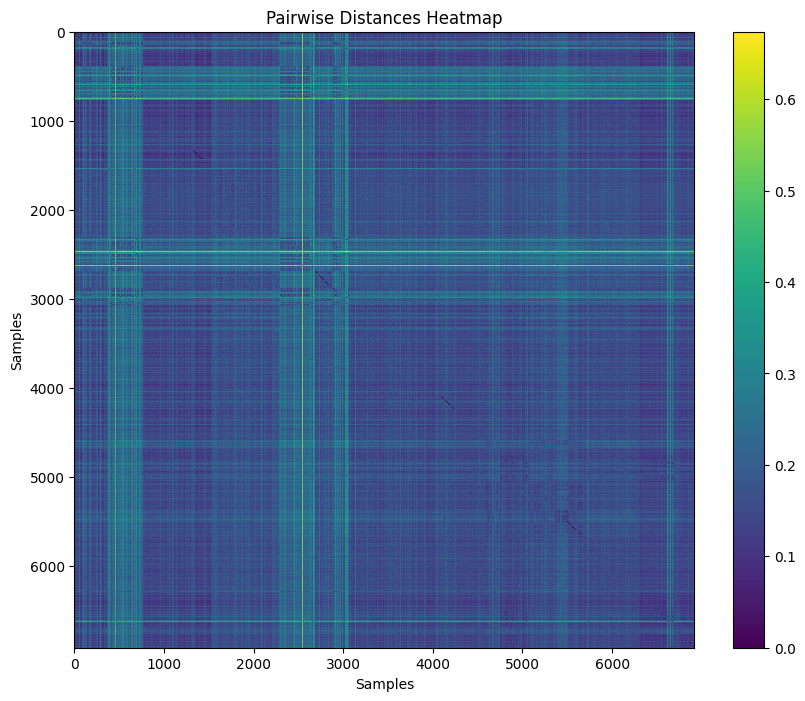

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# Compute pairwise distances for all features
distances = pairwise_distances(train_feature)

# Create a label matrix where each element indicates whether pairs belong to the same class
same_class = npY[:, None] == npY

# Compute average intra-class distance (same class)
avg_intra_class_distance = np.sum(distances * same_class) / np.sum(same_class)

# Compute average inter-class distance (different classes)
avg_inter_class_distance = np.sum(distances * ~same_class) / np.sum(~same_class)

# Display the averages
print(f"Average Intra-class Distance: {avg_intra_class_distance}")
print(f"Average Inter-class Distance: {avg_inter_class_distance}")
sorted_indices = np.argsort(npY)
sorted_distances = distances[sorted_indices, :][:, sorted_indices]

# Plotting the heatmap
plt.figure(figsize=(10, 8))
plt.title("Pairwise Distances Heatmap")
heatmap = plt.imshow(sorted_distances, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(heatmap)
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

The observed intra-class distance indicates that feature vectors within the same class are more similar to each other, which is good for class cohesion. However, the inter-class distance is not quite ideal, as it is too small for clear separation of classes. This probably means that the features are not discriminative enough, that more features are needed, and more advanced feature transformation methods may be required.

The pairwise differences heatmap is mostly homogeneous save for a few vertical and horizontal bands. These bands likely represent outliers, or features that are significantly different from the others. These bands are the only distinctive regions in the mostly homogeneous heatmap, which indicates that most of the feature vectors are very similar to each other and that there is an overlap of classes. This, too, is a symptom that calls for more complex models.

Building a nearest neighbor classifier to see actual classification performance:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, Y_train, Y_test = train_test_split(train_feature, npY, test_size=0.2, random_state=42)

# Initialize the KNeighborsClassifier with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Fit the classifier to the training data
knn.fit(X_train, Y_train)

# Predict on the test set
Y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Classification accuracy: {accuracy:.4f}")


Classification accuracy: 0.8793


Given our issues with class separation, a classification accuracy of 87.53% is impressive. It may be due to some class imbalance in the data (more of the images are natural than unnatural). Overall, this accuracy is better than baseline (a random classifier) and would serve as a good foundation for further work.

# 4.1 Extra Analysis: Non-Linear Dimensionality Reduction

As an additional step in our analysis of the data set, we will use non-linear dimensionality reduction on our image data and compare its accuracy to our previously computed linear dimension reduction using PCA.

In [ ]:
%%time
from sklearn.decomposition import KernelPCA

# Perform PCA
n_components = 600  # Specify the number of components - lower means faster computing but less quality, we want to retain around 95% of variance, so need to find sweet spot
print(f"Extracting the top {n_components} principal components from {npX_scaled.shape[0]} images")

kpca = KernelPCA(n_components=n_components, kernel='rbf',
                fit_inverse_transform=True, gamma=12, # very sensitive to the gamma parameter,
                remove_zero_eig=True)
kpca.fit(npX_scaled.copy())

Extracting the top 600 principal components from 6919 images
CPU times: user 2min 31s, sys: 10.6 s, total: 2min 42s
Wall time: 1min 42s


KernelPCA(fit_inverse_transform=True, gamma=12, kernel='rbf', n_components=600,
          remove_zero_eig=True)

# 4.2 Comparing the Non-Linear Method to the Linear Method


In [ ]:
# convert_to_grey will be used for compute the SSIM
def convert_to_grey(data):
    ori_recover=data
    ori_recover=np.trunc(ori_recover*255)
    ori_recover=np.array(ori_recover,dtype=np.uint8)
    ori_recover=cv2.cvtColor(ori_recover, cv2.COLOR_BGR2GRAY)
    return ori_recover

In [ ]:
# So let write a "simple" Structural Similarity(SSIM) function
# This will stop us from being biased against a certain type of PCA
def SSIM(X,Y):

    # we don't want the luminosity to be a factor. So before compute SSIM,
    # we need to make X,Y in the same luminosity level
    Y=Y*(X.sum()/Y.sum())

    ux=X.mean()
    uy=Y.mean()

    sigma2x=(X-ux)**2
    sigma2y=(Y-uy)**2
    sigmaxy=(X-ux)*(Y-uy)
    sigma2x=sigma2x.mean()
    sigma2y=sigma2y.mean()
    sigmaxy=sigmaxy.mean()

    k1=0.01
    k2=0.03
    L=255
    c1=(k1*L)**2
    c2=(k2*L)**2
    c3=c2/2

    l=(2*ux*uy+c1)/(ux*ux+uy*uy+c1)
    c=(2*sigma2x**1/2 * sigma2y**1/2 +c2)/(sigma2x+sigma2y+c2)
    s=(sigmaxy+c3)/(sigma2x**1/2  * sigma2y**1/2 +c3)
    re=l*c*s
    return re

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(IntSlider(value=749, description='idx_to_reconstruct', max=1499), Output()), _dom_classe…

<function __main__.plt_reconstruct(idx_to_reconstruct)>

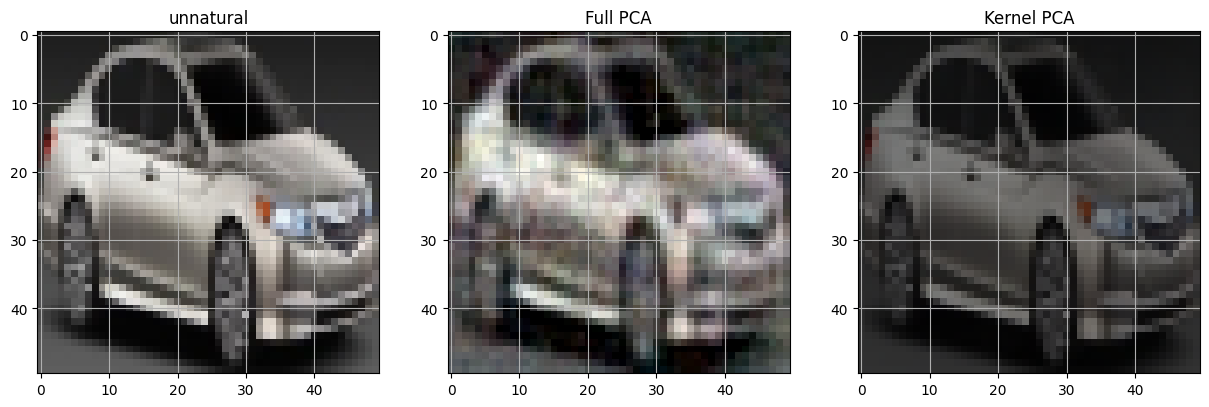

In [ ]:
from ipywidgets import widgets
import warnings
n_samples=1500

warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)

    reconstructed_image = pca.inverse_transform(pca.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))
    plt.figure(figsize=(15,7))

    ## original image
    plt.subplot(1,3,1)
    plt.imshow(npX_scaled[idx_to_reconstruct].reshape((50, 50,3))[:,:,[2,1,0]])
    plt.title(npY[idx_to_reconstruct])
    plt.grid()
    ori_grey=convert_to_grey(npX_scaled[idx_to_reconstruct].reshape((50, 50,3))[:,:,[2,1,0]])

    ## Full PCA image
    plt.subplot(1,3,2)
    full_pca_recover=reconstructed_image.reshape((50, 50,3))
    full_pca_recover=full_pca_recover[:,:,[2,1,0]]
    plt.imshow(full_pca_recover)

    plt.title('Full PCA')
    plt.grid()
    full_pca_grey=convert_to_grey(full_pca_recover)
    print('Similarity after normalizing luminosity of Full PCA and Original Image, SSIM = %s' % SSIM(ori_grey,full_pca_grey))

    ## KPCA image
    plt.subplot(1,3,3)
    kpca_recover=reconstructed_image_kpca.reshape((50, 50,3))
    kpca_recover=kpca_recover[:,:,[2,1,0]]
    plt.imshow(kpca_recover)
    plt.title('Kernel PCA')
    plt.grid()
    kpca_grey=convert_to_grey(kpca_recover)
    print('Similarity after normalizing luminosity of Kernal PCA and Original Image, SSIM = %s' % SSIM(ori_grey,kpca_grey))

widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

From the three images above, we can see that while the pixel colors of the original image and the Full PCA image are similar, the clarity of Full PCA is worse than Kernel PCA. We cannot only use mean squared error to determine our comparison's accuracy because mean squared error sums the squares of the pixels' difference. This would mean that, while MSE(pic1, pic2) and MSE(pic1, pic3) might have the same value, pic2 and pic3 could be totally different. Kernal PCA reconstructs images into a different pixel range than their original image, but the human eye can't differentiate by itself. Because of this, we might care more about an image's "structure" rather than exact pixel values being preserved.

The following code block calculates the "structural similarity" between Full PCA and the Original as well as the that same score between Kernel PCA and the Original using our function defined above.

In [ ]:
# This function return 2 SSIM value : Full PCA and Original Image and Kernel PCA and Original Image
def compute_SSIM(idx_to_reconstruct):
    reconstructed_image = pca.inverse_transform(pca.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(npX_scaled[idx_to_reconstruct].reshape(1, -1)))

    ## original image
    ori_grey=convert_to_grey(npX_scaled[idx_to_reconstruct].reshape((50, 50,3))[:,:,[2,1,0]])

    ## Full PCA image
    full_pca_recover=reconstructed_image.reshape((50, 50,3))
    full_pca_recover=full_pca_recover[:,:,[2,1,0]]
    full_pca_grey=convert_to_grey(full_pca_recover)

    ## KPCA image
    kpca_recover=reconstructed_image_kpca.reshape((50, 50,3))
    kpca_recover=kpca_recover[:,:,[2,1,0]]
    kpca_grey=convert_to_grey(kpca_recover)

    return SSIM(ori_grey,full_pca_grey),SSIM(ori_grey,kpca_grey)

%time compute_SSIM(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 423 ms, sys: 224 ms, total: 647 ms
Wall time: 587 ms


(0.7880532247885754, 0.8661932766994168)

These results show that the structural similarity between the Kernel PCA generated image and the Original image is higher than the Full PCA and the Original. This is reflected by how we observe the three example images generated above: while we would say that the Full PCA created image matches the colors and pixel values more accurately to the original, it also looks less like the original than the Kernel PCA generated image.

# References

1. https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb

2. https://github.com/eclarson/MachineLearningNotebooks/blob/master/03.%20DataVisualization.ipynb

3. https://www.kaggle.com/datasets/prasunroy/natural-images

4. https://github.com/XingmingQu/SMU-Machine-Learning-7000/blob/master/Lab2.ipynb